# Assignment 2: Adult Census Income

**Module:** COMP47490 Machine Learning, Autumn 2021  
**Student:** Rajit Banerjee, 18202817  
**Data:** `../data/US_Census_18202817.csv` (source of sample: https://archive.ics.uci.edu/ml/datasets/adult)

**Problem statement**: 
- Given a sample of the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/adult), the objective is to use the ensemble learning functionality to identify the extent to which classification performance can be improved through the combination of multiple models.
- The data contains 14 attributes including age, race, sex, marital status etc, and the goal is to predict whether the individual earns over $50K per year.

Import all required packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **scikit-learn: version 1.0.1**
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import BaggingClassifier

# **imbalanced-learn: version 0.8.1**
from imblearn.over_sampling import SMOTE

%matplotlib inline

## 1A: Data Preparation

### 1. Load and explore data

In [2]:
%%time
df = pd.read_csv("../data/US_Census_18202817.csv")
df_raw = df.copy()
df.head()

CPU times: user 4.69 ms, sys: 1.29 ms, total: 5.97 ms
Wall time: 6.97 ms


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
0,60,Private,225014,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
1,34,Private,196164,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
2,25,Private,184698,10th,6,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,Dominican-Republic,<=50K
3,29,Federal-gov,41013,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,55,United-States,<=50K
4,27,Private,193898,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K


In [3]:
df.shape

(5000, 15)

The dataset has 5000 observations, 14 predictor features and 1 target.

Descriptive statistics for numerical features:

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5000.0,38.5146,13.499475,17.0,28.00,37.0,47.25,90.0
fnlwgt,5000.0,190610.7524,111696.961238,18827.0,117358.75,177948.0,239581.25,1484705.0
education-num,5000.0,10.0304,2.584107,1.0,9.00,10.0,12.00,16.0
capital-gain,5000.0,1097.0114,7713.004802,0.0,0.00,0.0,0.00,99999.0
capital-loss,5000.0,85.6324,400.497188,0.0,0.00,0.0,0.00,3900.0
hours-per-week,5000.0,40.5162,12.674978,1.0,40.00,40.0,45.00,99.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               5000 non-null   int64 
 1    workclass        5000 non-null   object
 2    fnlwgt           5000 non-null   int64 
 3    education        5000 non-null   object
 4    education-num    5000 non-null   int64 
 5    marital-status   5000 non-null   object
 6    occupation       5000 non-null   object
 7    relationship     5000 non-null   object
 8    race             5000 non-null   object
 9    sex              5000 non-null   object
 10   capital-gain     5000 non-null   int64 
 11   capital-loss     5000 non-null   int64 
 12   hours-per-week   5000 non-null   int64 
 13   native-country   5000 non-null   object
 14   Income-category  5000 non-null   object
dtypes: int64(6), object(9)
memory usage: 586.1+ KB


Preliminary inspection suggests that no missing values exist.

The UCI Machine Learning Repository provides some information about the various attributes:

Listing of attributes: 

- `age`: continuous.  
- `workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.  
- `fnlwgt`: continuous.   
- `education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  
- `education-num`: continuous.   
- `marital-status`: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.   
- `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.  
- `relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- `race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- `sex`: Female, Male.  
- `capital-gain`: continuous.   
- `capital-loss`: continuous.   
- `hours-per-week`: continuous.   
- `native-country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- `Income-category`: `>50K, <=50K`. 

### 2. Trim white space

Clean the column names to remove extra white space.

In [6]:
df.columns = df.columns.str.strip()
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income-category'],
      dtype='object')

Remove leading or trailing white space from all string (object) type attributes.

In [7]:
for col in df.select_dtypes(["object"]):
    df[col] = df[col].str.strip()

### 3. Check for duplicates

In [8]:
# Check rows
df[df.duplicated(keep=False)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category


In [9]:
# Check columns
dfT = df.T  # transpose dataframe and perform same check as done for rows
dfT[dfT.duplicated(keep=False)]

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999


No rows or columns in the dataset are duplicated.

### 4. Check for constant columns

In [10]:
df.select_dtypes(["object"]).describe().T

,count,unique,top,freq
workclass,5000,9,Private,3448
education,5000,16,HS-grad,1634
marital-status,5000,7,Married-civ-spouse,2331
occupation,5000,15,Craft-repair,652
relationship,5000,6,Husband,2084
race,5000,5,White,4266
sex,5000,2,Male,3381
native-country,5000,38,United-States,4487
Income-category,5000,2,<=50K,3818


In [11]:
df.nunique()

age                  70
workclass             9
fnlwgt             4580
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain         83
capital-loss         56
hours-per-week       78
native-country       38
Income-category       2
dtype: int64

All categorical attributes have cardinality > 1, hence there are no constant columns in the dataset.

### 5. Data visualisation

A visual inspection of the distribution of variables will allow us to understand the dataset and spot any unusual observations.

**Bar charts** for object/string-valued (essentially categorical) variables:

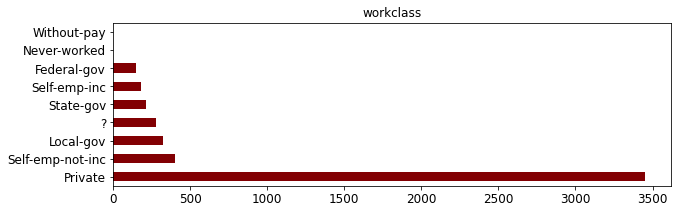

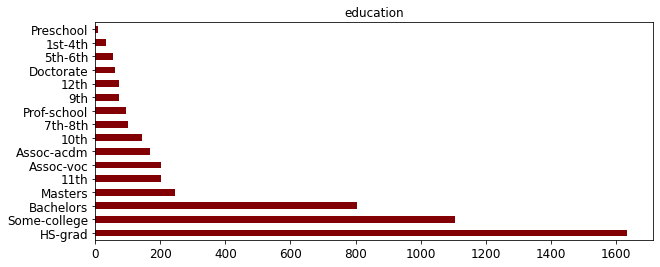

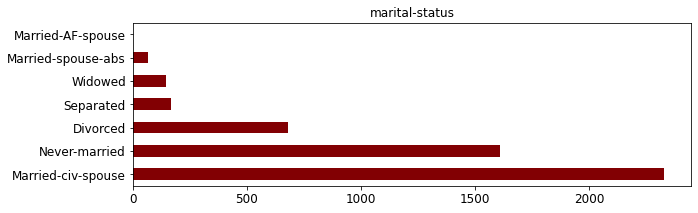

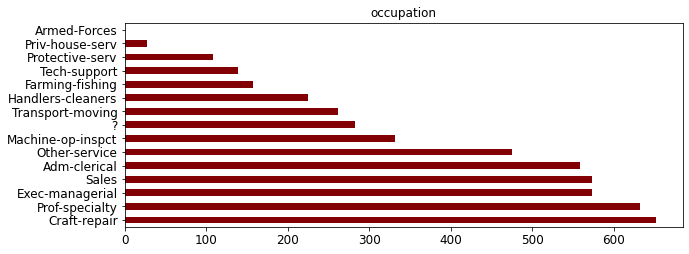

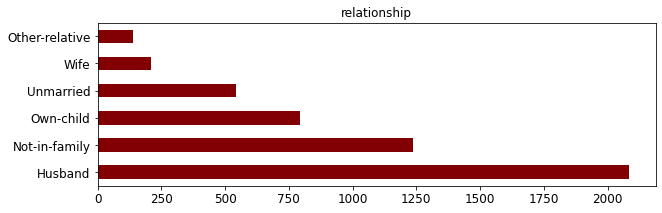

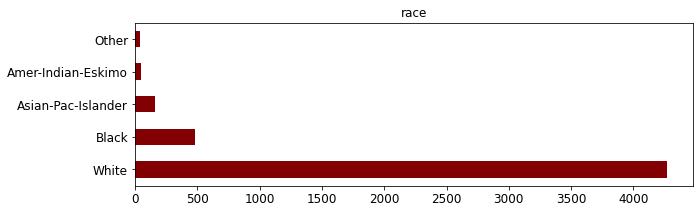

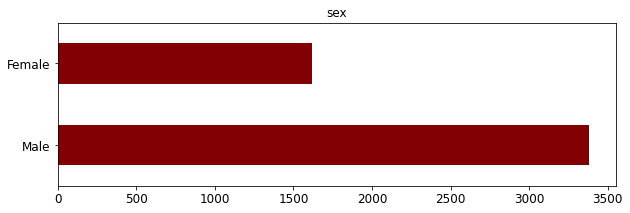

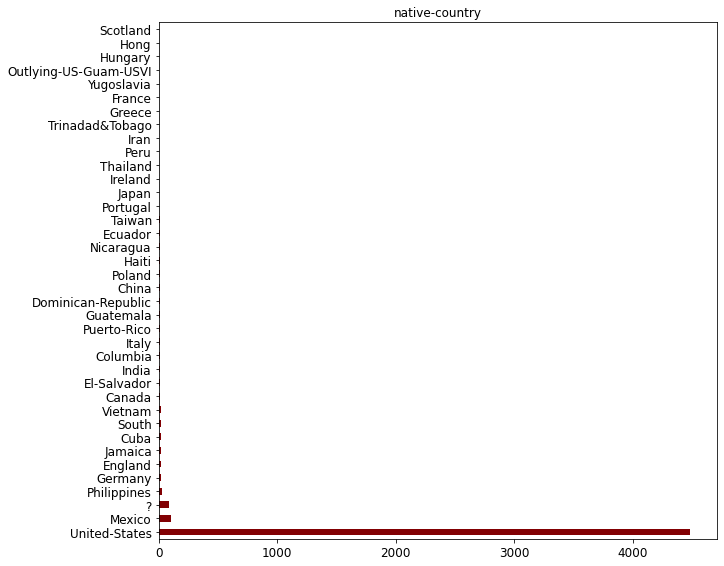

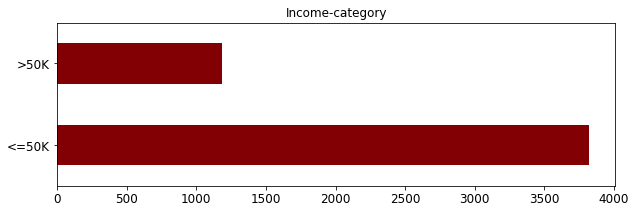

In [12]:
for col in df.select_dtypes(["object"]).columns:
    counts = df[col].value_counts(dropna=False)
    n = len(counts)  
    counts.plot(kind="barh", title=col, figsize=(10, max(3, n/4)), fontsize=12, color="#820003")
    plt.show()

Insights from bar charts:

- Missing/unknown values exist in `workclass`, `occupation` and `native-country`, but they were hidden as `?` symbols (instead of nulls). 
- For the following attributes, generalisation would be appropriate (such as combining all minority groups) since the vast majority of observations belong to one group (dominant):
    - `workclass` (dominant: `Private`)
    - `race` (dominant: `White`)
    - `native-country` (dominant: `United-States`)

**Histograms** for numerical variables:

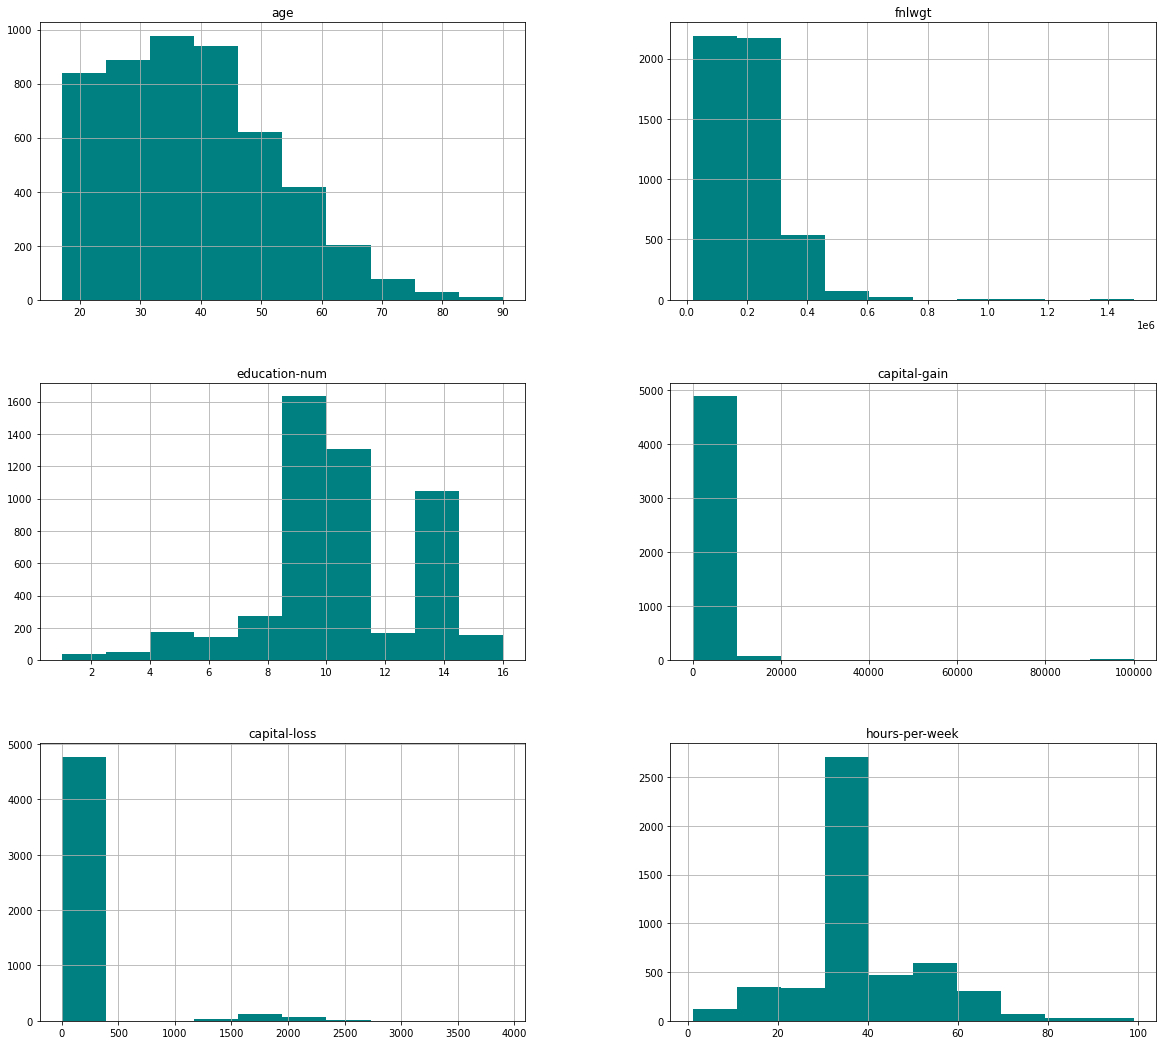

In [13]:
df.hist(figsize=(20, 25), layout=(4, 2), color="#008080");

Insights from histograms:

- As age increases beyond 40-45, the number of the observations drops rapidly.
- The distributions for `capital-gain` and `capital-loss` are extremely right skewed.
- The majority of `hours-per-week` observations lie between 30-40 hours.

In [14]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income-category'],
      dtype='object')

### 6. Feature correlations

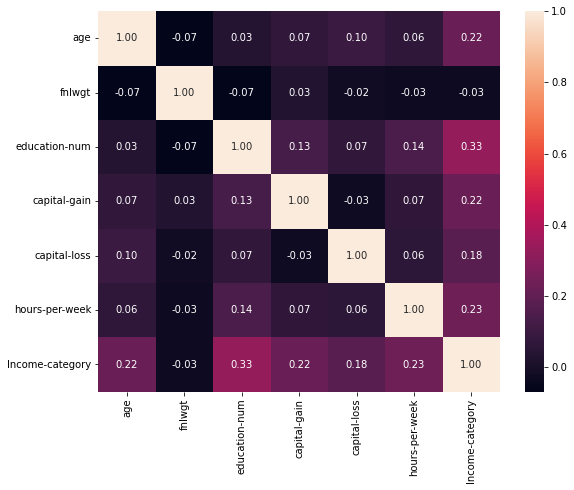

In [15]:
# Convert target class to a binary variable
df["Income-category"] = df["Income-category"].map({">50K": 1, "<=50K": 0})

plt.figure(figsize=(9, 7))
sns.heatmap(data=df.corr(), annot=True, fmt = ".2f")
plt.show()

- The above heatmap shows that none of the features have a particularly high linear correlation with the target `Income-category`.
- The `fnlwgt` attribute's negligible correlation score with the target stands out above.

### 7. Data quality and encoding plan

Any data types that need to be changed are expressed in the format `old_type -> new_type`.

| No. | Feature | Data type | Plan of action |
| --- | --- | --- | --- |
| 01 | `age` | `int64` | Group into intervals. Apply ordinal encoding. |
| 02 | `workclass` | `object -> uint8` | Replace `?` with NaN. One dominant group exists: convert to binary variable, 1 if Private, else 0. |
| 03 | `fnlwgt` | `int64` | This is the number of people the census believes the entry represents. Too many distinct values and no linear correlation with target. **Drop** column. |
| 04 | `education` | `object -> int64` | Regroup levels of education. Apply ordinal encoding. |
| 05 | `education-num` | `int64` | Required information is already presented as (and regrouped with) `education`. **Drop** column.  |
| 06 | `marital-status` | `object -> uint8` | Apply one-hot encoding.  |
| 07 | `occupation` | `object -> uint8` | Replace `?` with NaN. Apply one-hot encoding. |
| 08 | `relationship` | `object -> uint8` | Apply one-hot encoding. |
| 09 | `race` | `object -> uint8` | One dominant group exists: convert to binary variable, 1 if White, else 0. |
| 10 | `sex` | `object -> uint8` | Binary encode as 1 if Male, else 0. |
| 11 | `capital-gain` | `int64` | Highly skewed distribution. Explore further. |
| 12 | `capital-loss` | `int64` | Highly skewed distribution. Explore further. |
| 13 | `hours-per-week` | `int64` | Usual hours per week are around 30-40. Data can be grouped into 3 buckets: less than 30, 30 to 40, over 40. Then, apply ordinal encoding. |
| 14 | `native-country` | `object -> uint8` | Replace `?` with NaN. One dominant group exists: convert to binary variable, 1 if United-States, else 0. |

### 8. Deal with redundancy and unknowns

We can drop the `fnlwgt` attribute, as explained in the plan table. Moreover, although we initially thought that no values were missing, they were essentially hidden as `?`, which can now be converted to `NaN`.

In [16]:
df.drop(columns="fnlwgt", inplace=True)

In [17]:
df[df == "?"] = np.nan
df.isnull().sum()

age                  0
workclass          281
education            0
education-num        0
marital-status       0
occupation         283
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country      86
Income-category      0
dtype: int64

The missing values in 3 attributes now need to be handled before proceeding further. Since the data is skewed, we can use the modal value in each column to replace unknowns.

In [18]:
for col in ["workclass", "occupation", "native-country"]:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [19]:
df["workclass"].value_counts()

Private             3729
Self-emp-not-inc     402
Local-gov            324
State-gov            215
Self-emp-inc         179
Federal-gov          148
Never-worked           2
Without-pay            1
Name: workclass, dtype: int64

In [20]:
df["occupation"].value_counts()

Craft-repair         935
Prof-specialty       632
Exec-managerial      574
Sales                573
Adm-clerical         559
Other-service        475
Machine-op-inspct    332
Transport-moving     262
Handlers-cleaners    225
Farming-fishing      157
Tech-support         139
Protective-serv      108
Priv-house-serv       28
Armed-Forces           1
Name: occupation, dtype: int64

In [21]:
df["native-country"].value_counts().head(10) # display only top 10

United-States    4573
Mexico            103
Philippines        26
Germany            22
England            20
Jamaica            16
Cuba               16
South              16
Vietnam            15
Canada             14
Name: native-country, dtype: int64

In [22]:
# Verification
df.isnull().sum().sum()

0

### 9. Deal with `age` and `hours-per-week` (binning and ordinal encoding)

Numerical variables `age` and `hours-per-week` can be binned and ordinal encoded as described in the quality/encoding plan.

In [23]:
# Binning
df["age"] = pd.cut(df["age"], bins=3)
df["age"].value_counts()

(16.927, 41.333]    3052
(41.333, 65.667]    1773
(65.667, 90.0]       175
Name: age, dtype: int64

The ages have been binned into 3 equal-width intervals as shown above. The majority of observations are in the 17-41 (approx.) age group.

In [24]:
# Ordinal encoding
df["age"] = df["age"].astype("category").cat.codes
df["age"].value_counts()

0    3052
1    1773
2     175
Name: age, dtype: int64

In [25]:
# 3 groups: less than 30 hours, 30-40 hours, over 40 hours
def bin_and_encode_hrs(hrs: int) -> int:
    if hrs < 30:
        return 0
    elif hrs > 40:
        return 2
    else:
        return 1


df["hours-per-week"] = df["hours-per-week"].apply(bin_and_encode_hrs)
df["hours-per-week"].value_counts()

1    2868
2    1485
0     647
Name: hours-per-week, dtype: int64

The majority of `hours-per-week` observations are in the 30-40 hours group (code: `1`).

### 10. Deal with `education` (regroup and encode)

We use the pre-encoded `education-num` to regroup and encode `education`.

In [26]:
df["education-num"].value_counts()

9     1634
10    1106
13     805
14     245
7      202
11     201
12     169
6      144
4      100
15      94
5       73
8       72
16      62
3       53
2       32
1        8
Name: education-num, dtype: int64

In [27]:
df["education"].value_counts()

HS-grad         1634
Some-college    1106
Bachelors        805
Masters          245
11th             202
Assoc-voc        201
Assoc-acdm       169
10th             144
7th-8th          100
Prof-school       94
9th               73
12th              72
Doctorate         62
5th-6th           53
1st-4th           32
Preschool          8
Name: education, dtype: int64

All levels from `Preschool` to `12th` can grouped into one category: adults who didn't complete school-level education (`HS-grad` is not included).

In [28]:
def encode_ed(row: int) -> int:
    ed = row["education-num"]
    # 1: Preschool, 8: 12th
    if 1 <= ed <= 8:
        return 0
    else:
        return ed - 8

    
df["education"] = df.apply(lambda row: encode_ed(row), axis=1)

The new encoding is as follows:

- 0: Preschool to 12th
- 1: HS-grad
- 2: Some-college
- 3: Assoc-voc
- 4: Assoc-acdm 
- 5: Bachelors
- 6: Masters
- 7: Prof-school
- 8: Doctorate

Since `education-num` is no longer necessary, we can drop it.

In [29]:
df.drop(columns="education-num", inplace=True)

In [30]:
df["education"].value_counts()

1    1634
2    1106
5     805
0     684
6     245
3     201
4     169
7      94
8      62
Name: education, dtype: int64

### 11. Deal with `workclass`, `race`, `native-country`,  `sex` (convert to binary)

- In the given dataset, there are only 2 distinct values for `sex`, which can thus be binarised.
- The vast majority of `native-country` instances are `United-States`, which is expected since the data comes from the US Census. Hence, this variable can also be binarised by putting all non-US countries in a group. Similarly, `Private` in `workclass` and `White` in `race` are dominant (1), allowing all other groups to be combined as 0.

In [31]:
def binarise(col: str, dominant: str) -> None:
    df[col] = df[col].apply(lambda x: 1 if x == dominant else 0)


binarise("workclass", "Private")
binarise("race", "White")
binarise("native-country", "United-States")
binarise("sex", "Male")

# Binary variables only need enough space for uint8
bin_vars = ["workclass", "race", "sex", "native-country",  "Income-category"]
for col in bin_vars:
    df[col] = df[col].astype("uint8")

# Display value counts
for col in bin_vars:
    print(f"{'-' * 38}\n{df[col].value_counts(dropna=False)}")

--------------------------------------
1    3729
0    1271
Name: workclass, dtype: int64
--------------------------------------
1    4266
0     734
Name: race, dtype: int64
--------------------------------------
1    3381
0    1619
Name: sex, dtype: int64
--------------------------------------
1    4573
0     427
Name: native-country, dtype: int64
--------------------------------------
0    3818
1    1182
Name: Income-category, dtype: int64


### 12. Deal with `marital-status`, `occupation`, `relationship` (one-hot encoding)

The following variables are categorical in nature (unordered) and need to be one-hot encoded. We can directly change the data type from object to binary (1/0, uint8) by applying one-hot encoding.

In [32]:
categorical_vars = ["marital-status", "occupation", "relationship"]
df = pd.concat([df.drop(columns=categorical_vars), 
                pd.get_dummies(df[categorical_vars], prefix=categorical_vars)],
              axis=1)
    
df.head()

,age,workclass,education,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,1,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,7,1,0,0,0,2,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,5,1,1,0,0,2,1,1,...,0,1,0,0,1,0,0,0,0,0


### 13. Deal with `capital-gain` and `capital-loss`

In [33]:
df["capital-gain"].value_counts().head(10)

0        4601
15024      51
7688       37
7298       35
99999      27
5178       17
3103       13
4386       12
4064        9
6849        9
Name: capital-gain, dtype: int64

In [34]:
df["capital-loss"].value_counts().head(10)

0       4774
1977      33
1902      29
1887      27
1485      14
1602       9
1876       7
1848       7
1980       5
2179       4
Name: capital-loss, dtype: int64

We notice that the vast majority of observations show no capital gain or loss. Since the two variables convey similar information, we can drop them after constructing a new feature called `capital-diff` to store the difference between capital gain and loss.

In [35]:
df["capital-diff"] = df["capital-gain"] - df["capital-loss"]
df.drop(columns=["capital-gain", "capital-loss"], inplace=True)

Then, we can encode all net losses as -1, no difference as 0, and net gains as 1.

In [36]:
def encode_diff(val: int) -> int:
    if val > 0:
        return 1
    elif val < 0:
        return -1
    else:
        return 0
    
    
df["capital-diff"] = df["capital-diff"].apply(encode_diff).astype("int8")
df["capital-diff"].value_counts()

 0    4375
 1     399
-1     226
Name: capital-diff, dtype: int64

### 14. Inspect clean and encoded dataset

In [37]:
df.head()

,age,workclass,education,race,sex,hours-per-week,native-country,Income-category,marital-status_Divorced,marital-status_Married-AF-spouse,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,capital-diff
0,1,1,1,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,7,1,0,2,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,5,1,1,2,1,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                5000 non-null   int8 
 1   workclass                          5000 non-null   uint8
 2   education                          5000 non-null   int64
 3   race                               5000 non-null   uint8
 4   sex                                5000 non-null   uint8
 5   hours-per-week                     5000 non-null   int64
 6   native-country                     5000 non-null   uint8
 7   Income-category                    5000 non-null   uint8
 8   marital-status_Divorced            5000 non-null   uint8
 9   marital-status_Married-AF-spouse   5000 non-null   uint8
 10  marital-status_Married-civ-spouse  5000 non-null   uint8
 11  marital-status_Married-spouse-abs  5000 non-null   uint8
 12  marital-status_Never

At this point, we are comfortable with the degree of cleanliness of our dataset.
We have:
- 5000 observations (none dropped)
- 35 predictor features (after feature engineering and encoding)
- 1 target variable

### 15. Evaluation measure selection

To avoid data peeking, we must split the dataset into train and test sets, and only use the training data for feature selection and model fitting. The test set will only be used for evaluation, and not during model training.

In [39]:
X = df.drop("Income-category", axis=1)
y = df["Income-category"]

- 30% of the observations are set aside for testing.
- Integer-valued `random_state` ensures reproducible results.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) 
X_train.shape, X_test.shape

((3500, 35), (1500, 35))

In [41]:
def get_perc(y):
    vc = y.value_counts()
    return vc/sum(vc) * 100
    
get_perc(y)

0    76.36
1    23.64
Name: Income-category, dtype: float64

Due to the 3:1 class imbalance, we set `stratify=y` to maintain the imbalance when doing the split above. 

In [42]:
get_perc(y_train)

0    76.371429
1    23.628571
Name: Income-category, dtype: float64

One way to deal with class imbalance is to resample the training data. The method adopted here is over-sampling of the minority class using the SMOTE algorithm [Ref: N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002]. Until the data is balanced, SMOTE randomly chooses a point from the minority class, finds its k-nearest neighbours, then places a new point on the line connecting the chosen point and a chosen neighbour.

In [43]:
X_train_bal, y_train_bal = SMOTE(random_state=0).fit_resample(X_train, y_train)
X_train_bal.shape

(5346, 35)

In [44]:
get_perc(y_train_bal)

1    50.0
0    50.0
Name: Income-category, dtype: float64

- Since the training dataset is now perfectly balanced, we can use **classification accuracy** as the primary metric to compare models.
- ROC (receiver operating characteristic) curves plot the True Positive rate against the False Positive rate, and are a good measure of a classifier's skill (compared to a dummy classifier). ROC is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The area under this curve (AUC) can also be used to quantitatively compare classifiers. 

In [45]:
# defining the metric to be used for evaluation from here on
metric = "accuracy"

## 1B: Basic Classifiers

### 1. Hyperparameter tuning

The "best" arguments (called hyperparameters) used when training classifiers can be found using a systematic trial and error approach. All searches use a stratified 5-fold **cross-validation** where in each of 5 experiments, 4 "folds" are used for training and 1 for testing. This is preferable to a naive hold-out strategy as it increases the generalisation capabilities of a model by reducing the chances of overfitting.

During the entire process of tuning hyperparameters, no access to the testing data set is granted. Model parameters are optimised solely using the training set (which has been upsampled).

In [46]:
def grid_search(clf, param_grid):
    # n_jobs=-1 forces the algorithm to use all available CPUs and generally provides a speed-up
    grid = GridSearchCV(clf, param_grid, scoring=metric, cv=5, verbose=1, n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best = grid.best_estimator_

    print(f"\nBest: {best}")
    print(f"Average {metric}: {grid.best_score_:.3f}\n")
    return best

#### i. Decision Tree

- `criterion` is the quality measure for a node split.
- `max_depth` refers to the maximum depth of the tree (*constraint*: at most 3).
- `min_samples_leaf` is minimum number of samples required to be at a leaf node.

In [47]:
%%time
dt = DecisionTreeClassifier(random_state=0)
dt_best = grid_search(dt, {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(1, 4), # depth <= 3
    "min_samples_leaf": range(1, 11),
})

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best: DecisionTreeClassifier(max_depth=3, random_state=0)
Average accuracy: 0.772

CPU times: user 360 ms, sys: 160 ms, total: 519 ms
Wall time: 1.32 s


#### ii. Neural Network (Multi-Layer Perceptron or MLP)

- `hidden_layer_sizes` is a tuple controlling the number of nodes/neurons in the neural network's hidden layers (*constraint*: at most 10 nodes are allowed in total).
- `activation` function used for hidden layers is a key part of neural networks, and is data-dependent.

ADAM (adaptive moment estimation) is the default solver used for weight optimisation, and generally works well when thousands of training examples are available.
The number of epochs is set at 200 by default.

In [48]:
%%time
mlp = MLPClassifier(random_state=0)
mlp_best = grid_search(mlp, {
    "hidden_layer_sizes": [(2, 2, 2, 2, 2), (4, 3, 3), (4, 4, 2), (5, 5), (10,)],
    "activation": ["logistic", "tanh", "relu"],
})

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti


Best: MLPClassifier(hidden_layer_sizes=(10,), random_state=0)
Average accuracy: 0.835

CPU times: user 790 ms, sys: 43.4 ms, total: 833 ms
Wall time: 11.9 s


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### iii. K-Nearest Neighbours

- `n_neighbors` specifies the number of neighbours used by k-NN (*constraint*: 1-NN).
- `leaf_size` affects the speed of the construction and query, as well as the memory required to store the tree in BallTree or KDTree algorithms for k-NN computation.
- `metric` specifies the distance metric to be used.

In [49]:
%%time
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn_best = grid_search(knn, {
    "leaf_size": [1, 2, 5, 10, 15, 20, 25, 30],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
})

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best: KNeighborsClassifier(leaf_size=1, metric='manhattan', n_jobs=-1, n_neighbors=1)
Average accuracy: 0.775

CPU times: user 163 ms, sys: 51.3 ms, total: 214 ms
Wall time: 4.04 s


### 2. Evaluation

Hyperparameter optimisation yields 3 "best" base classifiers below subject to the constraints mentioned earlier.

In [50]:
best_clfs = [dt_best, mlp_best, knn_best]
best_clfs

[DecisionTreeClassifier(max_depth=3, random_state=0),
 MLPClassifier(hidden_layer_sizes=(10,), random_state=0),
 KNeighborsClassifier(leaf_size=1, metric='manhattan', n_jobs=-1, n_neighbors=1)]

A **confusion matrix** summarises every classifier's performance by revealing the True Positives, True Negatives, False Positives and False Negatives. Some measures based on these values include: precision, recall (sensitivity), specificity (True Negative rate), etc. The test set that was initially set aside is finally used for evaluation. 

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


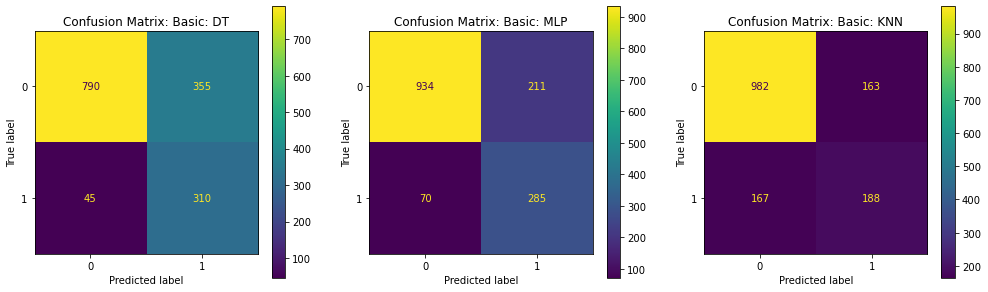

In [51]:
def extract_clf_name(clf, method) -> str:
    def abbreviate(clf_name) -> str:
        if clf_name == "DecisionTreeClassifier":
            return "DT"
        elif clf_name == "MLPClassifier":
            return "MLP"
        elif clf_name == "KNeighborsClassifier":
            return "KNN"
            
    estimator = clf if method in ["Basic", "Tuned"] else clf.base_estimator
    return f"{method}: {abbreviate(estimator.__class__.__name__)}"


def plot_conf_matrix(classifiers: list, method="Basic"):
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    for i, clf in enumerate(classifiers):
        clf_name = extract_clf_name(clf, method)
        clf.fit(X_train_bal, y_train_bal)
        
        disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[i])
        disp.ax_.set_title(f"Confusion Matrix: {clf_name}")


plot_conf_matrix(best_clfs)

A common scoring function can be defined to consistently evaluate all classifiers. Using a stratified 5-fold cross-validation (benefits discussed earlier) on the full dataset, the classifiers' performance is returned (based on average accuracy). Stratification is used to maintain target class imbalance in the pre-split dataset.

In [52]:
def score(classifiers: list, cv=StratifiedKFold(n_splits=5), method="Basic") -> pd.DataFrame:
    scores = {}
    for clf in classifiers:
        clf_name = extract_clf_name(clf, method)
        
        # Final scoring using stratified k-fold cross-validation on entire pre-split data
        ts = cross_val_score(clf, X, y, cv=cv, n_jobs=-1, scoring=metric)
        scores[clf_name] = f"{ts.mean():.3f} +/- {ts.std():.3f}"

    scores_df = pd.DataFrame.from_dict(scores, orient="index", columns=["Avg. accuracy"])
    print("Classifiers in descending order of performance:")
    return scores_df.sort_values(by=scores_df.columns[0], ascending=False)


scores_basic = score(best_clfs)
scores_basic

Classifiers in descending order of performance:


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

,Avg. accuracy
Basic: MLP,0.839 +/- 0.004
Basic: DT,0.818 +/- 0.009
Basic: KNN,0.784 +/- 0.022


As discussed when choosing evaluation metrics, ROC curves are useful for comparing different classifiers with each other and also with a random classifier.

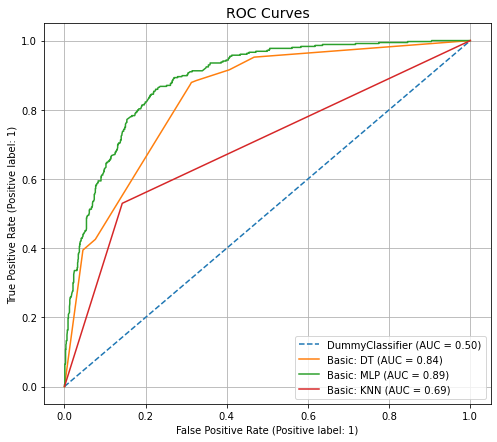

In [53]:
def plot_roc_curves(classifiers: list, pos_label=1, method="Basic"):
    # Baseline
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train_bal, y_train_bal)
    disp = RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test,
                                          pos_label=pos_label, linestyle="--")

    for clf in classifiers:
        clf_name = extract_clf_name(clf, method)
        disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, name=clf_name,
                                              pos_label=pos_label, ax=disp.ax_)
    disp.ax_.grid()
    disp.figure_.set_size_inches(8, 7)
    disp.ax_.set_title(f"ROC Curves", fontsize=14)


plot_roc_curves(best_clfs)

All basic classifiers above are better than random, as shown by the AUC (area under the curve) scores (perfect skill => AUC = 1.0), with both the neural network and decision tree performing far better than 1-NN.

## 1C: Bagging Ensemble

The key idea behind bagging (bootstrap aggregation) ensembles is that a number of classifiers trained on different random samples of training data will improve performance.

### 1. Hyperparameter tuning

Using the 3 basic classifiers obtained earlier, we can vary the ensemble size from 2 to 20 (in steps of 2).

In [54]:
ensemble_size = range(2, 21, 2)
perc_instances = [0.25, 0.5, 0.75, 1.0]

#### i. Decision Tree

In [55]:
%%time
dt_bag = BaggingClassifier(dt_best, random_state=0, n_jobs=-1)
dt_bag = grid_search(dt_bag, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=0),
                  n_estimators=20, n_jobs=-1, random_state=0)
Average accuracy: 0.776

CPU times: user 93.7 ms, sys: 57.6 ms, total: 151 ms
Wall time: 683 ms


Using the best performing ensemble size, we can now vary the percentage of instances in bootstrap samples (drawn **with** replacement by default).

In [56]:
%%time
dt_bag_best = grid_search(dt_bag, { "max_samples": perc_instances })

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=0),
                  max_samples=0.25, n_estimators=20, n_jobs=-1, random_state=0)
Average accuracy: 0.776

CPU times: user 33.4 ms, sys: 8.83 ms, total: 42.2 ms
Wall time: 440 ms


Similar to decision trees above, we can apply the same bagging strategy for the basic neural network and 1-NN classifiers.

#### ii. Neural Network

In [57]:
%%time
mlp_bag = BaggingClassifier(mlp_best, random_state=0, n_jobs=-1)
mlp_bag = grid_search(mlp_bag, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Best: BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                               random_state=0),
                  n_estimators=20, n_jobs=-1, random_state=0)
Average accuracy: 0.836

CPU times: user 258 ms, sys: 128 ms, total: 386 ms
Wall time: 1min 58s


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
%%time
mlp_bag_best = grid_search(mlp_bag, { "max_samples": perc_instances })

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti


Best: BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                               random_state=0),
                  n_estimators=20, n_jobs=-1, random_state=0)
Average accuracy: 0.836

CPU times: user 162 ms, sys: 79.2 ms, total: 242 ms
Wall time: 1min 10s


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

#### iii. K-Nearest Neighbours

In [59]:
%%time
knn_bag = BaggingClassifier(knn_best, random_state=0, n_jobs=-1)
knn_bag = grid_search(knn_bag, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best: BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                      metric='manhattan',
                                                      n_jobs=-1,
                                                      n_neighbors=1),
                  n_estimators=18, n_jobs=-1, random_state=0)
Average accuracy: 0.837

CPU times: user 110 ms, sys: 164 ms, total: 275 ms
Wall time: 19.6 s


In [60]:
%%time
knn_bag_best = grid_search(knn_bag, { "max_samples": perc_instances })

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best: BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                      metric='manhattan',
                                                      n_jobs=-1,
                                                      n_neighbors=1),
                  n_estimators=18, n_jobs=-1, random_state=0)
Average accuracy: 0.837

CPU times: user 44.6 ms, sys: 52.1 ms, total: 96.7 ms
Wall time: 6.67 s


### 2. Evaluation

Hyperparameter optimisation for bagging ensembles yields the 3 best classifiers below.

In [61]:
best_bags = [dt_bag_best, mlp_bag_best, knn_bag_best]
best_bags

[BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   max_samples=0.25, n_estimators=20, n_jobs=-1, random_state=0),
 BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                                random_state=0),
                   n_estimators=20, n_jobs=-1, random_state=0),
 BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                       metric='manhattan',
                                                       n_jobs=-1,
                                                       n_neighbors=1),
                   n_estimators=18, n_jobs=-1, random_state=0)]

As seen before, confusion matrices provide a good overall summary of classifier performance on unseen data. 

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

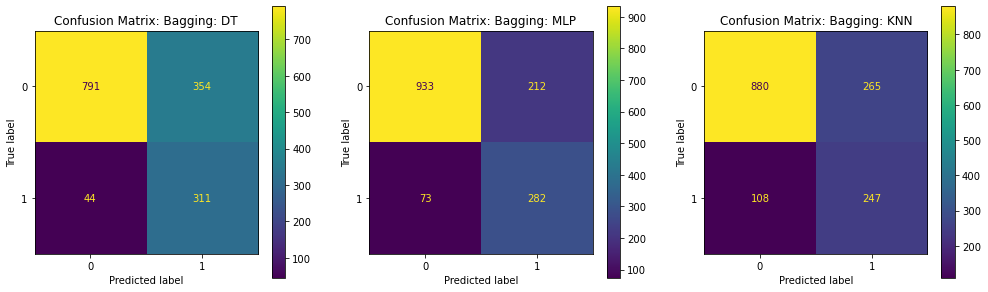

In [62]:
plot_conf_matrix(best_bags, method="Bagging")

The ensembles can now be scored and ranked after stratified 5-fold cross-validation.

In [63]:
scores_bag = score(best_bags, method="Bagging")
scores_bag

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

Classifiers in descending order of performance:


,Avg. accuracy
Bagging: MLP,0.840 +/- 0.008
Bagging: DT,0.823 +/- 0.008
Bagging: KNN,0.809 +/- 0.011


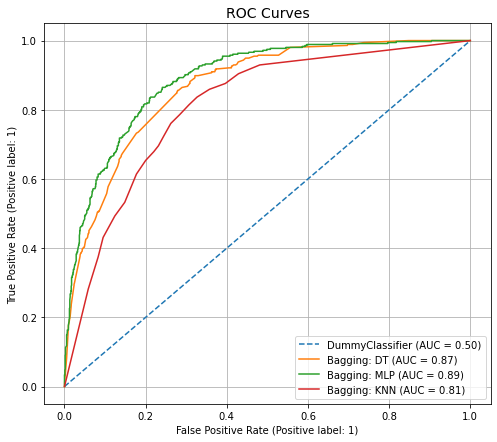

In [64]:
plot_roc_curves(best_bags, method="Bagging")

The ROC curves above show that bagging ensembles of neural networks and decision trees are still better than 1-NN.

## 1D: Random Subspacing Ensemble

Instead of sampling training examples, random subspacing ensembles rely on training multiple base classifiers using samples of features (drawn **without** replacement by default).

### 1. Hyperparameter tuning

Using the 3 basic classifiers obtained earlier, we can vary the ensemble size from 2 to 20 (in steps of 2) for decision trees, neural networks and 1-NN. Then, using the best performing ensemble size, we can vary the percentage of features used for random subspacing.

In [65]:
ensemble_size = range(2, 21, 2)
perc_features = [0.25, 0.5, 0.75, 1.0]

#### i. Decision Tree

In [66]:
%%time
dt_ss = BaggingClassifier(dt_best, max_features=0.5, random_state=0, n_jobs=-1)
dt_ss = grid_search(dt_ss, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=0),
                  max_features=0.5, n_estimators=6, n_jobs=-1, random_state=0)
Average accuracy: 0.781

CPU times: user 74.3 ms, sys: 26.4 ms, total: 101 ms
Wall time: 736 ms


In [67]:
%%time
dt_ss_best = grid_search(dt_ss, { "max_features": perc_features })

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=0),
                  max_features=0.5, n_estimators=6, n_jobs=-1, random_state=0)
Average accuracy: 0.781

CPU times: user 44.4 ms, sys: 30.5 ms, total: 75 ms
Wall time: 944 ms


#### ii. Neural Network

In [68]:
%%time
mlp_ss = BaggingClassifier(mlp_best, max_features=0.5, random_state=0, n_jobs=-1)
mlp_ss = grid_search(mlp_ss, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti


Best: BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                               random_state=0),
                  max_features=0.5, n_estimators=8, n_jobs=-1, random_state=0)
Average accuracy: 0.806

CPU times: user 219 ms, sys: 94 ms, total: 313 ms
Wall time: 1min 53s


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

In [69]:
%%time
mlp_ss_best = grid_search(mlp_ss, { "max_features": perc_features })

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti


Best: BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                               random_state=0),
                  n_estimators=8, n_jobs=-1, random_state=0)
Average accuracy: 0.831

CPU times: user 63.4 ms, sys: 19.3 ms, total: 82.7 ms
Wall time: 37.5 s


#### iii. K-Nearest Neighbours

In [70]:
%%time
knn_ss = BaggingClassifier(knn_best, max_features=0.5, random_state=0, n_jobs=-1)
knn_ss = grid_search(knn_ss, { "n_estimators": ensemble_size })

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best: BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                      metric='manhattan',
                                                      n_jobs=-1,
                                                      n_neighbors=1),
                  max_features=0.5, n_estimators=20, n_jobs=-1, random_state=0)
Average accuracy: 0.816

CPU times: user 107 ms, sys: 116 ms, total: 223 ms
Wall time: 18 s


In [71]:
%%time
knn_ss_best = grid_search(knn_ss, { "max_features": perc_features })

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best: BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                      metric='manhattan',
                                                      n_jobs=-1,
                                                      n_neighbors=1),
                  max_features=0.75, n_estimators=20, n_jobs=-1,
                  random_state=0)
Average accuracy: 0.841

CPU times: user 56.2 ms, sys: 59.9 ms, total: 116 ms
Wall time: 10.7 s


### 2. Evaluation

Hyperparameter optimisation for random subspacing ensembles yields the 3 best classifiers below.

In [72]:
best_ss = [dt_ss_best, mlp_ss_best, knn_ss_best]
best_ss

[BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   max_features=0.5, n_estimators=6, n_jobs=-1, random_state=0),
 BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                                random_state=0),
                   n_estimators=8, n_jobs=-1, random_state=0),
 BaggingClassifier(base_estimator=KNeighborsClassifier(leaf_size=1,
                                                       metric='manhattan',
                                                       n_jobs=-1,
                                                       n_neighbors=1),
                   max_features=0.75, n_estimators=20, n_jobs=-1,
                   random_state=0)]

Plotting confusion matrices using the test dataset and scoring the classifiers using cross-validation are familiar evaluation strategies that we can apply for random subspacing ensembles below.

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

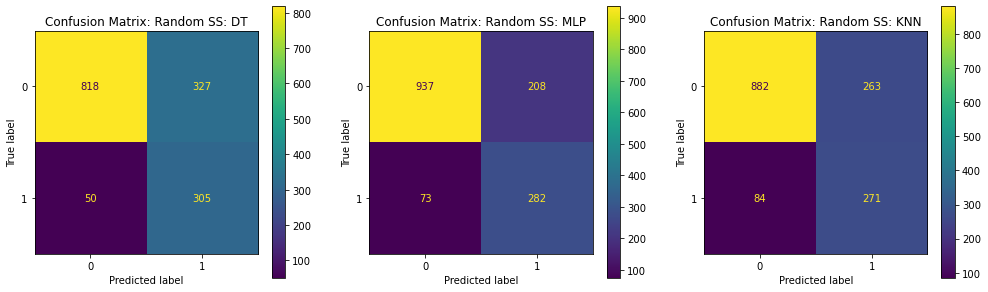

In [73]:
plot_conf_matrix(best_ss, method="Random SS")

In [74]:
scores_ss = score(best_ss, method="Random SS")
scores_ss

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

Classifiers in descending order of performance:


,Avg. accuracy
Random SS: MLP,0.839 +/- 0.008
Random SS: KNN,0.818 +/- 0.012
Random SS: DT,0.814 +/- 0.009


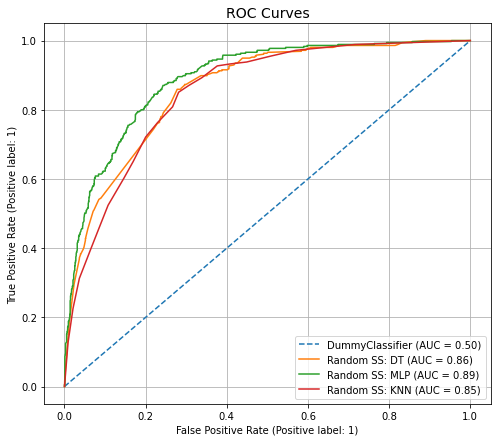

In [75]:
plot_roc_curves(best_ss, method="Random SS")

The ROC curves above show that the difference in skill between 1-NN and DT/MLP is smaller when using random subspacing, compared to earlier when bagging was applied.

## 1E: Discussion of Ensemble Methods

In general, we expect unstable classifiers (such as decision trees and neural networks) to benefit more from bagging than random subspacing ensembles. The latter is usually shown to improve the performance of stable classifiers like k-NN.

A summary of classifier performance (in terms of average cross-validation accuracy) is presented below.

In [76]:
scores = pd.concat([scores_basic, scores_bag, scores_ss])
scores.sort_values(by=scores.columns[0], ascending=False)

,Avg. accuracy
Bagging: MLP,0.840 +/- 0.008
Random SS: MLP,0.839 +/- 0.008
Basic: MLP,0.839 +/- 0.004
Bagging: DT,0.823 +/- 0.008
Random SS: KNN,0.818 +/- 0.012
Basic: DT,0.818 +/- 0.009
Random SS: DT,0.814 +/- 0.009
Bagging: KNN,0.809 +/- 0.011
Basic: KNN,0.784 +/- 0.022


In the given dataset, we see from the table above that:
- Neural networks (MLP) have benefited from **bagging**, whereas random subspacing showed no marked changes.
- For decision trees (DT), similar to neural networks, **bagging** results in a marked improvement.
- K-nearest neighbours (KNN) shows far greater improvement with the **random subspacing** ensemble technique, compared to bagging.

The results seen above are more or less in line with expectations mentioned earlier.

Diversity and possible improvements:

- There is possibly a lack of diversity (a certain level of disagreement between voters) in ensembles above.
- There is no definite measure of diversity, but it usually stabilises with an ensemble size of 10-50. 
- To improve the ensemble performance, we could have considered a greater number of estimators for bagging and random subspacing. Furthermore, boosting ensemble methods such as Random Forest, AdaBoost and Gradient Boosting could also be explored to see if they are better suited for the given dataset. 
- In the end, it is important to keep the mind the trade-offs between accuracy and ensemble diversity, as well that those between bias and variance when designing ensemble classifiers.

## 1F: Ensembles vs. Tuned Base Classifiers

It may also be useful to compare our existing ensembles of fairly weak learners with individual tuned classifiers. 

### 1. Hyperparameter tuning

We perform hyperparameter tuning to explore decision trees with maximum depth > 3, neural networks with more than 10 hidden nodes, and k-NN with k > 1 (dropping the weak learner constraints that we defined in the beginning). 

In [77]:
%%time
dt_tuned = grid_search(DecisionTreeClassifier(random_state=0), {
    "criterion": ["gini", "entropy"],
    "max_depth": range(2, 13, 2),
    "min_samples_leaf": [5, 10, 20, 50, 100],
})

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best: DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=5,
                       random_state=0)
Average accuracy: 0.802

CPU times: user 283 ms, sys: 64.5 ms, total: 348 ms
Wall time: 805 ms


In [78]:
%%time
mlp_tuned = grid_search(MLPClassifier(random_state=0), {
    "hidden_layer_sizes": [(10,), (10, 20, 10), (50, 50, 50), (100,), (150, 100, 50)],
    "activation": ["logistic", "tanh", "relu"],
})

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti


Best: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=0)
Average accuracy: 0.844

CPU times: user 1min 7s, sys: 15.4 s, total: 1min 22s
Wall time: 1min 15s


/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
%%time
knn_tuned = grid_search(KNeighborsClassifier(n_jobs=-1), {
    "n_neighbors": range(1, 21),
    "leaf_size": [1, 2, 5, 10],
    "metric": ["euclidean", "manhattan"]
})

Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best: KNeighborsClassifier(leaf_size=1, metric='euclidean', n_jobs=-1)
Average accuracy: 0.825

CPU times: user 874 ms, sys: 188 ms, total: 1.06 s
Wall time: 25.6 s


### 2. Evaluation

The tuned classifiers thus obtained are listed and scored below.

In [80]:
best_tuned = [dt_tuned, mlp_tuned, knn_tuned]
best_tuned

[DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=5,
                        random_state=0),
 MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
               random_state=0),
 KNeighborsClassifier(leaf_size=1, metric='euclidean', n_jobs=-1)]

In [81]:
scores_tuned = score(best_tuned, method="Tuned")
scores_tuned

/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rajitbanerjee/.local/share/conda/envs/comp47490-m1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Opti

Classifiers in descending order of performance:


,Avg. accuracy
Tuned: DT,0.829 +/- 0.005
Tuned: MLP,0.820 +/- 0.011
Tuned: KNN,0.819 +/- 0.007


In [82]:
scores = pd.concat([scores, scores_tuned])
scores.sort_values(by=scores.columns[0], ascending=False)

,Avg. accuracy
Bagging: MLP,0.840 +/- 0.008
Random SS: MLP,0.839 +/- 0.008
Basic: MLP,0.839 +/- 0.004
Tuned: DT,0.829 +/- 0.005
Bagging: DT,0.823 +/- 0.008
Tuned: MLP,0.820 +/- 0.011
Tuned: KNN,0.819 +/- 0.007
Random SS: KNN,0.818 +/- 0.012
Basic: DT,0.818 +/- 0.009
Random SS: DT,0.814 +/- 0.009


From the extended summary table above, we find:

- For decision trees, the tuned classifier surprisingly performs better than the basic constrained classifier's ensembles (bagging/random subspacing). 
- On the other hand, performance of the tuned neural network drops below that of the basic MLP model. This is possibly a result of overfitting on the training set for the given data, which is a known issue with deep neural networks.
- For k-NN, we see similar results as decision trees, with the tuned model performing better than the basic classifier as well its ensembles.

This shows that ensemble techniques generally improve performance of classifiers, but are not guranteed to be better than a well-tuned individual model. Alternative ensembles could be explored (such as boosting techniques) which might better fit the given dataset.

$$- * -$$

P.S. When performing hyperparameter tuning with GridSearchCV for neural networks, we can hide verbose warnings (`ConvergenceWarning: Stochastic Optimizer...`) with the code snippet below. The models do converge in the end, hence the intermediate convergence warnings are not of particular significance.

In [83]:
from IPython.display import HTML

def hide_warnings():
    return HTML('''<script>
    $('div.output_stderr').hide();
    </script>''')

hide_warnings()

"All models are wrong, but some are useful." <br/>
~ G. E. P. Box, "Science and statistics" (1976), Journal of the American Statistical Association, 71 (356): 791–799.

## 2: Machine Learning Concepts

**a)** Emma took a rapid antigen test for SARS-CoV-2 (popularly called Covid-19) and her test came out positive. The particular brand of antigen test that she used claims that in their clinical study, the test showed a sensitivity of 0.825 and a specificity of 1.00. Assuming that their claimed numbers are true and given that she has been tested positive, what is the probability that she is actually positive for SARS-CoV-2?

**Ans.**

Notation:
- C: Emma has been infected with SARS-CoV-2
- +ve: Positive test
- -ve: Negative test

Sensitivity (True Positive Rate) = $P(+ve | C)$ = 0.825<br/>
Specificity (True Negative Rate) = $P(-ve | C')$ = 1.00

Denoting the prevalence of COVID-19 in Ireland as $P(C)$  we can compute (following from Bayes' Theorem):

$$
\begin{align}
P(C | +ve) &= \frac{P(+ve | C).P(C)}{P(+ve)} \\
&= \frac{P(+ve | C).P(C)}{P(+ve | C).P(C) + P(+ve | C').P(C')} \\
&= \frac{P(+ve | C).P(C)}{P(+ve | C).P(C) + (1 - P(-ve | C')).P(C')} \\
&= \frac{(0.825)P(C)}{(0.825)P(C) + (1 - 1).P(C')} \\
&= \frac{(0.825)P(C)}{(0.825)P(C) + 0} \\
&= 1
\end{align}
$$

Using a test that is 100% specific implies that all infected individuals are correctly identified, i.e. there are **no false positives**.

Hence, with a positive test, the probability that Emma actually has SARS-CoV-2 is **100%**.

**b)** Comment on the interpretability of k-nearest neighbour, decision tree, SVM, random forest and a deep neural network. For each of these supervised learning techniques, <br/>
(i) how easy or difficult it is to explain the reason behind predictions to a layman, <br/>
(ii) can you easily find out which training examples need to be modified to change the prediction for a particular query and <br/>
(iii) can you find out the weight of the different features in your model?

**Ans.**

- **k-NN**:
    - Explaining k-NN is not too difficult, especially when considering a 2-dimensional example which can be visualised. The basic idea for classification involves majority voting based on a specified k number of neighbouring points. However, it doesn't provide the inherent reasoning for any two points being "similar" to each other, especially why the features may be correlated.
    - Of all the given models, it is probably the easiest to find the training examples to be modified to change a query prediction for k-NN. Attribute values can simply be modified to influence the neighbourhood points of a given query, resulting in a predictable k-NN output.
    - There is no straightforward way of determining feature importances in k-NN. Even in weighted k-NN, weights are assigned to different training examples instead of any particular features.
- **Decision Tree**:
    - Decision trees are arguably one of the most interpretable machine learning models. For a tree that is not too deep, it is easy to start at the root node and trace the decisions made by the model at every split.
    - If the feature attributes are altered, the entropy/feature importances responsible for node splitting are likely to change, which is why it is not easy to change training examples to alter a query prediction with decision trees.
    - A node is pure if all its examples belong to the same class. The weight/importance of a feature is proportional to the impurity decrease obtained if a given feature is used for node splitting. This is because the overall goal of decision trees is to select features that minimise the depth of the tree (and consequently the number of decisions) to quickly reach pure leaf nodes.
- **SVM (Support Vector Machine)**:
    - The basic intuition behind SVM is easy to interpret: finding the maximal margin hyperplane to separate two classes. However, when the classes are not separable, some mathematical understanding is required to discuss the kernel trick and the idea of looking for a hyperplane in higher dimensions where the classes may be linearly separable.
    - Although it is easy for linear cases (which is not characteristic of most real-world problems), it is not straightforward to alter examples to change query predictions when the classes are not linearly separable (since higher dimensions cannot be visualised).
    - If the SVM kernel used is linear, feature importances can be easily computed, but this is not possible for other kernels such as RBF or sigmoid, due to data transformation to higher dimensions.
- **Random Forest**:
    - Being an example of a decision tree ensemble, random forests can be explained as a model which uses a committee of decision trees (the more diverse, the better) to make decisions based on a voting strategy. In that sense, such models are more interpretable compared to SVM or deep neural networks.
    - Since a large number of decision trees are involved in the decision making process based on voting, it is nearly impossible to influence a query prediction by tampering with feature values.
    - Feature importances are an integral part of random forests, and are computed by aggregating the feature weights returned by each constituent decision tree, essentially stabilising the results and reducing the outcome variability.
- **Deep Neural Network**:
    - Deep neural networks are well-known to have great performance in various complex machine learning tasks, but are the hardest to explain to a layman. Even an experienced data scientist may only be able to explain some of the hyperparameters, such as the mathematics behind activation functions (tanh, sigmoid, relu, etc.) or weight optimisation solvers (ADAM, stochastic gradient descent, etc.). However, the actual working of such models is still considered as a black box which may be able to produce fantastic results without any explicit reasoning.
    - It is impossible to find out which features are more important, or which training examples need to be altered to change a query prediction, due to the same reason: deep neural networks are essentially black boxes.

**c)** What are the relative advantages and disadvantages of agglomerative and divisive hierarchical clustering algorithms with respect to each other? What are the advantages and disadvantages of the different cluster metrics used in the agglomerative approaches?

**Ans.**

Agglomerative and divisive approaches fall under the group of hierarchical clustering algorithms, as opposed to partitioning methods such as k-means.

| Agglomerative clustering | Divisive clustering |
| --- | --- |
| Bottom-up strategy. | Top-down strategy. |
| Starting with each item in its own cluster, similar clusters are merged two at a time. | Reverse of agglomerative approach starting with all points in a single cluster, with binary splits performed at each step. |
| Less accurate, since merging decisions are made based on locally available information only. | Better clustering solutions on average, due to the global data distribution being available when making splitting decisions. |
| Time complexity is $O(n^3)$ (can be optimised to $O(n^2 log n)$ or even $O(n^2)$. | Greater efficiency compared to agglomerative clustering, applying heuristics like k-means to choose splits. |

Different cluster metrics used in agglomerative approaches include:

- *Single linkage*: Cluster distance is the smallest pairwise distance between corresponding cluster items. With a large enough inter-cluster distance, single linkage is able to differentiate between non-elliptical cluster shapes. However, since the merge criterion is local, it tends to produce non-cohesive, elongated clusters.
- *Complete linkage*: Cluster distance is the largest pairwise distance between corresponding cluster items. This avoids the cluster point chaining effect seen with single linkage, and has a non-local merge criterion. Clusters formed are more compact, but complete linkage suffers from a sensitivity to noise and outliers.
- *Average linkage*: Provides a balance between single and complete linkage, and avoids the extremes of either large or too compact clusters. Although it is biased towards globular cluster shapes, it is less perturbed by noise in the data.

**d)** Unlike the batch gradient descent, the stochastic gradient descent is not guaranteed to monotonically improve the cost function. And, yet, in applications involving large datasets, it is often preferred over the batch gradient descent.
Why?

**Ans.**

- Stochastic gradient descent (SGD) is an iterative approximation algorithm that randomly considers a data point (slope/gradient) per iteration to try and find a local optimum for a given differentiable cost function. Iterations:

$$
w:=w-\eta \nabla Q_{i}(w).
$$
- Symbols:
  - Estimation $w$ that minimises the cost function $Q(w)$,
  - $\eta$  is a step size,
  - $Q_{i}(w)$ is the cost function value at the $i^{th}$ training example.



- On the other hand, batch gradient descent also tries to approach a local optimum, but requires the entire dataset to be present in memory for every iteration, in order to compute the average loss for each training example. This enormously increases the **computational complexity** when dealing with large datasets (leading to **slow convergence**), since entire dataset needs to be scanned at every step.

$$
{\displaystyle w:=w-\eta \nabla Q(w)=w-{\frac {\eta }{n}}\sum _{i=1}^{n}\nabla Q_{i}(w),}
$$

- Consequently, even though SGD doesn't guarantee a monotonic improvement of the cost function, it performs quite well in practice, and is often preferred over batch gradient descent as the computational effort at every step is trivial.
- To strike a balance, a method called mini-batch gradient descent is often used, which samples a small number of points at every iteration instead of going through the entire dataset or just choosing a single point.

**e)** Computing the exact solution for k-means clustering problem is NP-hard. How is it that k-means remains a highly popular clustering algorithm and is widely deployed in a range of applications and many different big data platforms?

**Ans.**

- Although k-means clustering is an NP-hard problem, a very popular and effective heuristic known an Lloyd's algorithm works well in practice.
- With a carefully chosen number of clusters ($k$), the heuristic can produce "good" clusters (according to metrics such as average silhouette width: low inter-cluster similarity, high intra-cluster similarity) for problems from various domains.
- However, Lloyd's algorithm can have arbitrarily poor performance and provides no guarantees.
- K-means is still widely used for clustering data since Lloyd's algorithm is **fast** (by limiting the number of iterations), easily **interpretable** and **implementable**, and generally works well when provided with good cluster initialisations (e.g. using k-means++).

**f)** Consider a clustering task where you have three well-separated clusters, but the first cluster has ten times more items than the other two clusters combined. If you were using the random cluster centre initialisation in Lloyd's algorithm, where are the three initial cluster centres likely to be? What will be the impact of that on the final output of Lloyd's algorithm? How will the situation change if you were to use k-means++ for finding the initial cluster centres?

**Ans.**

- Using random cluster centre initialisation, all 3 initial centres are much more likely to be located in the first cluster, due to the sheer difference in size with the other 2 clusters.
- This form of cluster initialisation will greatly affect Lloyd's algorithm, and will probably lead to k-means getting stuck in a local optimum. With more than 1 centroid initialised in the larger first cluster, Lloyd's algorithm will split it into multiple smaller clusters, even though they should be in the same one.
- In order to ensure that Lloyd's method converges with a good clustering solution, k-means++ is the preferred algorithm for centroid initialisation. The main idea behind it is as follows: when initialising clusters, **distance between centroids is maximised**. This is done by sampling points with a probability proportional to the distance to the closest cluster centre.
- K-means++ provides a **guaranteed** solution that is $O(\text{log} k)$ competitive to the optimal clustering.
- In the given dataset, it is mentioned that the clusters are well-separated, which would allow k-means++ to easily find 3 appropriate cluster centroids. Such a good initialisation will significantly improve the performance of Lloyd's algorithm in terms of resultant cluster quality (avoiding local optima, maximising average silhouette width (ASW)).

$$- * -$$